![pendulum](https://learning.oreilly.com/library/view/computational-dynamics-3rd/9780470686157/figs/0608.png)

Import the libraries to solve the dynamics equations of motion

In [98]:
import numpy as np
from numpy import sin,cos,pi
from scipy.linalg import *
from scipy.optimize import fsolve,root
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [99]:
def setdefaults():
  plt.rcParams.update({'font.size': 22})
  plt.rcParams['lines.linewidth'] = 3

In [125]:
setdefaults()

Define some definitions for $A$, $A_\theta$ and g

In [126]:
def rotA(theta):
    '''This function returns a 2x2 rotation matrix to convert the 
    rotated coordinate to the global coordinate system
    input is angle in radians'''
    A=np.zeros((2,2))
    A=np.array([[np.cos(theta), -np.sin(theta)],\
                [np.sin(theta),np.cos(theta)]])
    
    return A

def A_theta(theta):
    dAda=np.array([[-np.sin(theta), -np.cos(theta)],[np.cos(theta),-np.sin(theta)]])
    return dAda

def g(system='ms'):
    '''define gravity for m-s, ft-s,mm-s'''
    if system=='ms':
        return 9.81
    elif system=='fts':
        return 32.2
    elif system=='mms':
        return 9.81e3
    else:
        print('warning: system not defined yet, giving you 9.81 m/s/s')
        return 9.81
  

Define constraint formed by a pin constraint

In [102]:
def C_pin(q1,u1,q2,u2):
    '''q1 is generalized coordinate of body 1 [R1x,R1y,theta1]
       q2 is generalized coordinate of body 2 [R2x,R2y,theta2]'''
    q1=q1.reshape(3,1)
    q2=q2.reshape(3,1)
    #print(rotA(q1[2,0])@u1)
    #print(q1[0:2])
    #print(q1[0:2]+rotA(q1[2,0])@u1)
    Cpin=q1[0:2]+rotA(q1[2,0])@u1-q2[0:2]-rotA(q2[2,0])@u2
    return Cpin

In [127]:
q0=np.array([0,1,np.pi/2])
C_pin(q0[0:3],np.array([[-0.5],[0]]),np.array([[0],[0],[0]]),np.array([[0],[0]]))

array([[-3.061617e-17],
       [ 5.000000e-01]])

Define Jacobian of pin constraint

In [129]:
def Cq_pin(u1,a1,u2,a2):
    '''dR/dR = identity
       dA/dtheta = Atheta'''
    u1=np.reshape(u1,(2,-1))
    u2=np.reshape(u2,(2,-1))
    Cq_1=np.append(np.identity(2),A_theta(a1)@u1[0:2],axis=1)
    Cq_2=np.append(-np.identity(2),-A_theta(a2)@u2[0:2],axis=1)
    Cq_pin=np.append(Cq_1,Cq_2,axis=1)
    return Cq_pin

In [105]:
def C_bar(q,t,li):
    C=np.zeros((2,1))
    #print(C)
    C=C_pin(q[0:3],np.array([[-li/2],[0]]),np.array([[0],[0],[0]]),np.array([[0],[0]]))
    return C

The bar uses the first three columns of the pin-constraint Jacobian 

(unless you add q1 for the ground link)

In [130]:
def Cq_bar(q,t,li):
    q=q.reshape(3,1)
    Cq=Cq_pin(np.array([[-li/2],[0]]),q[2][0],np.array([[0],[0]]),0)
    return Cq[0:2,0:3]

$\mathbf{B_i}=[-\mathbf{C_{q_d}^{-1}C_{q_i}},~\bar{I}]^T$

In [108]:
def Bi_bar(q,t,li):
    '''B.T*M*B-B.T*Qe = 0 '''
    Cq = Cq_bar(q,t,li)
    Cqd=Cq[0:2,0:2]
    Cqi=Cq[0:2,2].reshape(2,1)
    #print(-np.linalg.inv(Cqd)@Cqi)
    Bi=np.vstack((-np.linalg.inv(Cqd)@Cqi,np.eye(1)))
    return Bi

Define equation of motion to return $\dot{y}=[\dot{\theta}^2,~\ddot{\theta}^2]^T$ and $\mathbf{q}$

In [110]:
li=1
q0=np.array([[li/2],[0],[0]])
def eom_bar(t,y,li,mi):
    global q0
    q0[2]=y[0]
    q=fsolve(lambda q: np.append(C_bar(q,t,li),q0[2]-y[0]).reshape(3,),q0, \
                  fprime= lambda q: np.vstack((Cq_bar(q,t,li),np.array([0,0,1]))))
    q0=q
    Bi=Bi_bar(q,t,li)
    M=np.diag([mi,mi,mi*li**2/12])
    Qe=np.array([[0],[-mi*g()],[0]])
    dy=np.zeros(y.shape)
    dy[0]=y[1]
    dy[1]=solve(Bi.T@M@Bi,Bi.T@Qe)
    return dy,q

The `solve_ivp` only solves odes of the form `dy=f(t,y)` so we create an ode function that fits this form.

Then, we can integrate and post-process.

In [111]:
li=1
mi=1
t=np.linspace(0,3)
def ode_bar(t,y):
    global li,mi
    dy,q=eom_bar(t,y,li,mi)
    return dy
sol=solve_ivp(lambda t,y:ode_bar(t,y),t_span=[0,3],y0=[0,0],t_eval=t)

Text(0.5, 1.0, 'independent general coord theta')

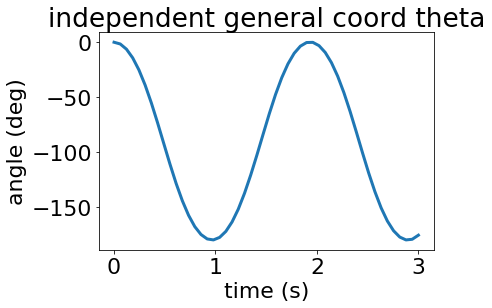

In [112]:
plt.plot(sol.t,sol.y[0]*180/np.pi)
plt.xlabel('time (s)')
plt.ylabel('angle (deg)')
plt.title('independent general coord theta')

We can plug in our solution `sol.y` for $\mathbf{q}$ as a function of time to get the other generalized coordinates.



In [131]:
q=np.zeros((3,len(t)))
for i,tt in enumerate(t):
    dy,qi=eom_bar(t,sol.y[:,i],li,mi)
    q[:,i]=qi

Text(0.5, 1.0, 'path of link COM')

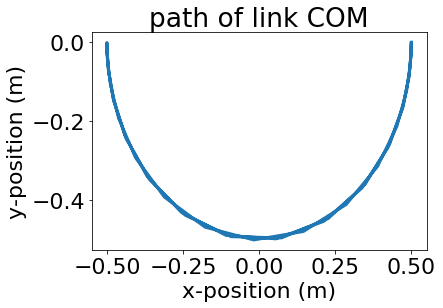

In [132]:
plt.plot(q[0,:],q[1,:])
plt.xlabel('x-position (m)')
plt.ylabel('y-position (m)')
plt.title('path of link COM')

and even animate our results 

In [133]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [134]:
def plot_shape(shape,dims,q):
    if shape=='link':
        Px=q[0]+np.array([dims[0]/2*np.cos(q[-1]),-dims[0]/2*np.cos(q[-1])])
        Py=q[1]+np.array([dims[0]/2*np.sin(q[-1]),-dims[0]/2*np.sin(q[-1])])
        l,= plt.plot(Px,Py,'o-')
        return l
    elif shape=='base':
        Px=q[0]
        Py=q[1]
        l,=plt.plot(Px,Py,'s',markersize=20)
        return l
    else:
        print('choose a \'link\' or \'base\' please')
        return 0

def plot_qs(q,shapes,dims,i):
    qi=q[:,i]
    f=plt.figure()
    if len(qi)/3 !=len(shapes):
        print('len(q) is %i. It needs %i more shapes '%(len(qi),len(qi)/3-len(shapes)))
    elif len(qi)/3==len(shapes):
        for i,s in enumerate(shapes):
            plot_shape(s,dims[i],qi[3*i:3*i+3])
            plt.plot(q[3*i,:],q[3*i+1,:])
        a=f.gca()
        plt.title('Angle 2 = %1.1f deg'%(qi[2]*180/pi))
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        a.axis([-1,1,-1,1])

In [135]:
interact(lambda i: plot_qs(q,['link'],[[li]],i), i=(0,len(t)-1))

interactive(children=(IntSlider(value=24, description='i', max=49), Output()), _dom_classes=('widget-interact'…

<function __main__.<lambda>(i)>